<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

В нашем распоряжении данные банка о клиентах, цель работы - спрогнозировать, уйдет ли клиент, построить модель с наибольшим значением F-1 меры. 
Для решения задачи предстоит выполнить следующие шаги:
1) Загрузить и подготовить данные.
2) Исследовать баланс классов, обучить модель без учёта дисбаланса.
3) Улучшить качество модели, учитывая дисбаланс классов. Обучить разные модели и найти лучшую.
4) Провести финальное тестирование.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os

pth1 = '/datasets/Churn.csv'
pth2 = '/Downloads/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')



In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Посмотрим, есть ли пустые значения в колонках.

In [4]:
df.loc[:, df.isna().any()]

,Tenure
0,2.0
1,1.0
2,8.0
3,1.0
4,2.0
...,...
9995,5.0
9996,10.0
9997,7.0
9998,3.0


In [5]:
df[df['Tenure'].isna()]['Exited'].mean()

0.20132013201320131

In [6]:
df[df['Tenure'].isna()]['IsActiveMember'].mean()

0.5104510451045104

In [7]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [8]:
df[df['Exited']==0]['Tenure'].isna().sum()


726

In [9]:
df[df['Exited']==1]['Tenure'].isna().sum()

183

Найдены пустые значения в колонке Tenure, нет оснований думать, что это ушедшие клиенты, так как в колонке Exited только около 20% из них отмечены ушедшими. Среди этих же клиентов около 51% являются активными пользователями банковских услуг. Несмотря на это, решено удалить все столбцы с nan, так как они занимают меньше 10% данных, к тому же, модель не может учиться на таких данных. 

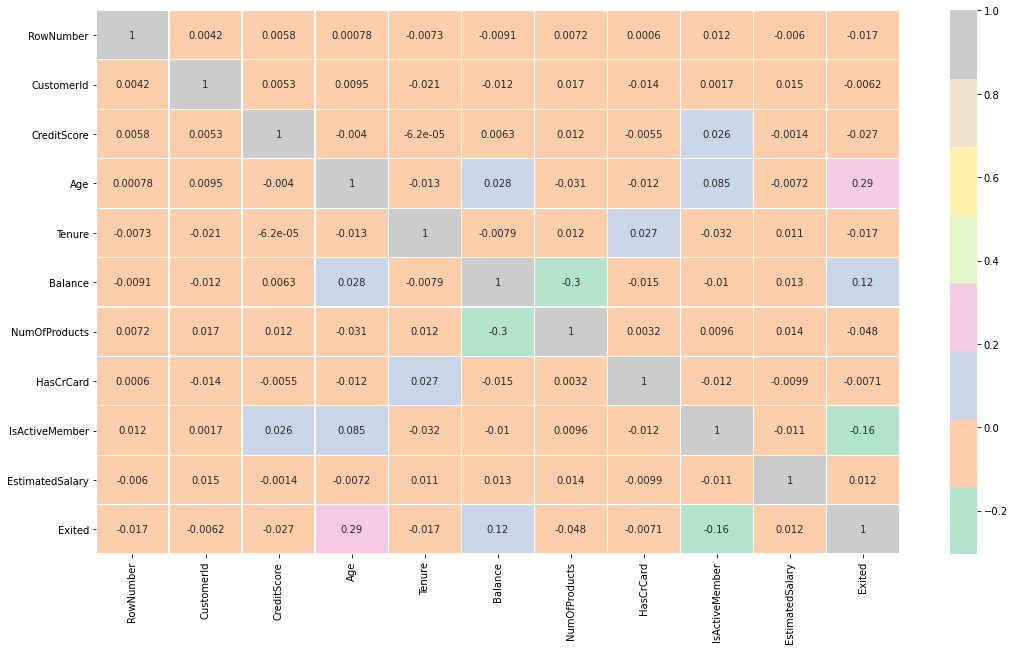

In [10]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, cmap='Pastel2', cbar=True, robust=False, linewidths=.2)
plt.show()

In [11]:
df = df.dropna(axis=0)

In [12]:
print(df['Surname'].unique())
print(df['Geography'].unique())
print(df['Gender'].unique())



['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']
['France' 'Spain' 'Germany']
['Female' 'Male']


В данных 3 столбца категориальных перменных, фамилии можно удалить, так как клиентов можно идентифицировать по уникальному номеру. Также можно удалить столбец RowNumber, конфликтует с индексацией таблицы, и CustomerId, возможно, он может ввести в заблуждение модель. Столбцы Geography и Gender переведем в численные через прямое кодирование. 

In [13]:
columns_to_drop = ['Surname', 'RowNumber', 'CustomerId']

df = df.drop(columns_to_drop, axis=1)


print(df.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42     2.0       0.00              1   
1          608     Spain  Female   41     1.0   83807.86              1   
2          502    France  Female   42     8.0  159660.80              3   
3          699    France  Female   39     1.0       0.00              2   
4          850     Spain  Female   43     2.0  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


In [14]:
df_ohe = pd.get_dummies(df, drop_first=True)
print(df_ohe.head())

   CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            

Посмотрим ближе на Age, Tenure, Balance, NumOfProducts, EstimatedSalary.

In [15]:
pd.options.display.float_format = '{:.2f}'.format
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_ohe[numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,9091.00,650.74,96.41,350.00,584.00,652.00,717.00,850.00
Age,9091.00,38.95,10.56,18.00,32.00,37.00,44.00,92.00
Tenure,9091.00,5.00,2.89,0.00,2.00,5.00,7.00,10.00
Balance,9091.00,76522.74,62329.53,0.00,0.00,97318.25,127561.89,250898.09
NumOfProducts,9091.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
EstimatedSalary,9091.00,100181.21,57624.76,11.58,51227.74,100240.20,149567.21,199992.48


Есть признаки с разными масштабами, например, возраст и суммы денег. Стандартизируем данные, чтобы алгоритм не решил, что суммы денег важнее возраста. 
Перед этим разделим данные на обучащую, тестовую и валидационную.

In [16]:
df_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.00,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.00,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.00,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.00,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.00,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2.00,0.00,2,0,0,167773.55,0,0,0,0
9995,771,39,5.00,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.00,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.00,0.00,1,0,1,42085.58,1,0,0,0


In [17]:
train, validate, test = \
              np.split(df_ohe.sample(frac=1, random_state=12345), 
                       [int(.6*len(df)), int(.8*len(df))])
display(train.shape)
display(validate.shape)
display(test.shape)

display(train.head())
display(validate.head())
display(test.head())



(5454, 12)

(1818, 12)

(1819, 12)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
862,725,41,7.00,113980.21,1,1,1,116704.25,0,0,0,1
9727,530,45,1.00,0.00,1,0,1,190663.89,1,0,0,0
1717,707,35,3.00,56674.48,1,1,0,17987.40,1,0,1,0
8640,730,32,9.00,127661.69,1,0,0,60905.51,0,0,0,0
5288,582,30,2.00,0.00,2,1,1,132029.95,0,0,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
1993,824,60,8.00,134250.17,3,0,0,153046.16,1,1,0,1
3023,618,39,2.00,91068.56,1,1,0,26578.69,0,0,0,1
396,557,33,3.00,54503.55,1,1,1,371.05,0,0,0,1
8888,743,23,3.00,110203.77,1,1,0,95583.45,0,0,0,1
1694,541,37,9.00,118636.92,1,1,1,73551.44,0,0,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
9138,578,59,10.00,185966.64,1,0,0,9445.42,1,0,0,1
4399,670,45,9.00,104930.38,1,1,0,155921.81,1,0,0,0
3299,825,34,9.00,0.00,2,1,1,31933.06,0,0,0,1
3121,634,27,3.00,107027.52,1,1,0,173425.68,0,1,0,1
436,627,30,4.00,79871.02,2,1,0,129826.89,0,1,0,0


In [18]:
features_train = train.drop('Exited', axis=1)
target_train = train['Exited']

features_valid = validate.drop('Exited', axis=1)
target_valid = validate['Exited']

features_test = test.drop('Exited', axis=1)
target_test = test['Exited']

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)


(5454, 11)
(1818, 11)
(1819, 11)


In [19]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.head())

      CreditScore   Age  Tenure  Balance  NumOfProducts  HasCrCard  \
862          0.75  0.19    0.69     0.60          -0.92          1   
9727        -1.27  0.57   -1.39    -1.22          -0.92          0   
1717         0.57 -0.37   -0.70    -0.31          -0.92          1   
8640         0.81 -0.66    1.38     0.82          -0.92          0   
5288        -0.73 -0.84   -1.05    -1.22           0.79          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
862                1             0.30                  0                0   
9727               1             1.58                  0                0   
1717               0            -1.42                  0                1   
8640               0            -0.68                  0                0   
5288               1             0.56                  0                0   

      Gender_Male  
862             1  
9727            0  
1717            0  
8640            0  
5288            

Данные подготовлены для исследования: нужные категориальные данные переведены в числовые методом прямого кодирования . Числовые переменные стандартизированы и приведены к одному масштабу. Удалены строки с пустыми и дублирующими значениями. Датасет разделен на 3 части в соотношении 3:1:1.

## Исследование задачи

In [20]:
df_ohe[df_ohe['Exited'] == 0].count()

CreditScore          7237
Age                  7237
Tenure               7237
Balance              7237
NumOfProducts        7237
HasCrCard            7237
IsActiveMember       7237
EstimatedSalary      7237
Exited               7237
Geography_Germany    7237
Geography_Spain      7237
Gender_Male          7237
dtype: int64

In [21]:
df_ohe[df_ohe['Exited'] == 1].count()

CreditScore          1854
Age                  1854
Tenure               1854
Balance              1854
NumOfProducts        1854
HasCrCard            1854
IsActiveMember       1854
EstimatedSalary      1854
Exited               1854
Geography_Germany    1854
Geography_Spain      1854
Gender_Male          1854
dtype: int64

<AxesSubplot:>

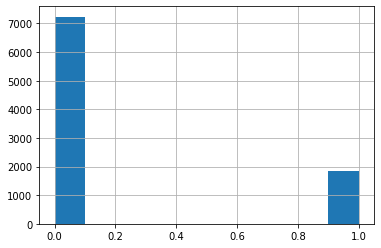

In [22]:
df_ohe['Exited'].hist()



In [ ]:
df['Exited'].value_counts(normalize=True).plot(kind='pie', autopct = "%0.0f%%", figsize=(6, 6))
plt.show()

В данных наблюдается дисбаланс классов, положительных ответов меньше практически в 4 раза. Построим 3 модели машинного обучения без корректировки дисбаланса, выявим  лучшую на основе тестовых данных.

**Дерево решений**

In [24]:
best_decision_tree_model = None
best_decision_tree_model_result = 0
for depth in range(1, 9):
	decision_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
	decision_tree_model.fit(features_train, target_train)
	predictions_decision_tree = decision_tree_model.predict(features_valid) 
	result = f1_score(target_valid, predictions_decision_tree) 
	if result > best_decision_tree_model_result:
		best_decision_tree_model = decision_tree_model
		best_decision_tree_model_result = result
        
print("F-1 мера лучшей модели DecisionTreeClassifier на валидационной выборке:", best_decision_tree_model_result)
print('Лучшая модель DecisionTree:', best_decision_tree_model)



F-1 мера лучшей модели DecisionTreeClassifier на валидационной выборке: 0.5423728813559322
Лучшая модель DecisionTree: DecisionTreeClassifier(max_depth=7, random_state=12345)


In [25]:
probabilities_valid = decision_tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)


0.8050897151264349


**Случайный лес**

In [26]:
%%time

best_random_forest_model = None
best_random_forest_model_result = 0
best_est = 0
best_depth = 0

for est in range(10, 101, 10):
    for depth in range(1, 21):
        random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        random_forest_model.fit(features_train, target_train) 
        predictions_random_forest = random_forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions_random_forest) 
        if result > best_random_forest_model_result:
            best_random_forest_model = random_forest_model 
            best_random_forest_model_result = result
            best_est = est
            best_depth = depth
            
            print(random_forest_model, end=' ')
            print(result)

print('F1-мера лучшей модели RandomForest на валидационной выборке:', best_random_forest_model_result)
print(best_est)
print(best_depth)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=12345) 0.15632183908045974
RandomForestClassifier(max_depth=3, n_estimators=10, random_state=12345) 0.20444444444444443
RandomForestClassifier(max_depth=4, n_estimators=10, random_state=12345) 0.4493554327808471
RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345) 0.49134948096885805
RandomForestClassifier(max_depth=6, n_estimators=10, random_state=12345) 0.5034013605442177
RandomForestClassifier(max_depth=7, n_estimators=10, random_state=12345) 0.5247524752475248
RandomForestClassifier(max_depth=8, n_estimators=10, random_state=12345) 0.5422077922077922
RandomForestClassifier(max_depth=9, n_estimators=10, random_state=12345) 0.5471999999999999
RandomForestClassifier(max_depth=11, n_estimators=10, random_state=12345) 0.5541795665634675
RandomForestClassifier(max_depth=15, n_estimators=10, random_state=12345) 0.557427258805513
RandomForestClassifier(max_depth=11, n_estimators=20, random_state=12345) 0.

In [27]:
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.843562394357988


**Логистическая регрессия**

In [28]:
from joblib import dump

logistic_regression_model = LogisticRegression(random_state=12345, solver='liblinear')
logistic_regression_model.fit(features_train, target_train)

predictions_logistic_regression = logistic_regression_model.predict(features_valid)
dump(logistic_regression_model, 'model_9_1.joblib')
logistic_regression_f1  = f1_score(target_valid, predictions_logistic_regression) 

print('F1- мера модели LogisticRegression на валидационной выборке:', logistic_regression_f1)



F1- мера модели LogisticRegression на валидационной выборке: 0.3244206773618538


In [29]:
probabilities_valid = logistic_regression_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7521287362168636


На валидационных данных без корректировки дисбаланса лучший показатель F-1 меры у модели случайного леса = 0.57, при этом AUC-ROC составляет 0.79.  

## Борьба с дисбалансом

Попытаемся улучшить результаты после корректировки балансов. Воспользуемся взвешиванием классов, увеличением или уменьшением выборки, изменением порогов.

**Взвешивание классов**

**Дерево решений**

In [30]:
best_decision_tree_model = None
best_decision_tree_model_result = 0
for depth in range(1, 9):
	decision_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced') 
	decision_tree_model.fit(features_train, target_train)
	predictions_decision_tree = decision_tree_model.predict(features_valid) 
	result = f1_score(target_valid, predictions_decision_tree) 
	if result > best_decision_tree_model_result:
		best_decision_tree_model = decision_tree_model
		best_decision_tree_model_result = result
        
print("F-1 мера лучшей модели DecisionTreeClassifier на валидационной выборке:", best_decision_tree_model_result)
print('Лучшая модель DecisionTree:', best_decision_tree_model)


F-1 мера лучшей модели DecisionTreeClassifier на валидационной выборке: 0.5755693581780539
Лучшая модель DecisionTree: DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=12345)


In [31]:
probabilities_valid = decision_tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)


0.7758923383158389


**Случайный лес**

In [32]:
%%time

best_random_forest_model = None
best_random_forest_model_result = 0
best_est = 0
best_depth = 0

for est in range(10, 101, 10):
    for depth in range(1, 21):
        random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                                     max_depth=depth, class_weight='balanced')
        random_forest_model.fit(features_train, target_train) 
        predictions_random_forest = random_forest_model.predict(features_valid)
        result = f1_score(target_valid, predictions_random_forest) 
        if result > best_random_forest_model_result:
            best_random_forest_model = random_forest_model 
            best_random_forest_model_result = result
            best_est = est
            best_depth = depth
            
            print(random_forest_model, end=' ')
            print(result)

print('F1-мера лучшей модели RandomForest на валидационной выборке:', best_random_forest_model_result)
print(best_est)
print(best_depth)

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=12345) 0.5212527964205815
RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=12345) 0.5473908413205537
RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=10,
                       random_state=12345) 0.5653495440729484
RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=10,
                       random_state=12345) 0.576882290562036
RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=10,
                       random_state=12345) 0.5819761129207383
RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=10,
                       random_state=12345) 0.5910112359550562
RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=10,
                       random_state=12345) 0.5959367945823928
RandomForestClassifie

In [33]:
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8460147903232359


**Логистическая регрессия**

In [34]:
logistic_regression_model = LogisticRegression(random_state=12345, solver='liblinear', 
                                               class_weight='balanced')
logistic_regression_model.fit(features_train, target_train)

predictions_logistic_regression = logistic_regression_model.predict(features_valid)
dump(logistic_regression_model, 'model_9_1.joblib')
logistic_regression_f1  = f1_score(target_valid, predictions_logistic_regression) 

print('F1- мера модели LogisticRegression на валидационной выборке:', logistic_regression_f1)



F1- мера модели LogisticRegression на валидационной выборке: 0.5052430886558628


In [35]:
probabilities_valid = logistic_regression_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7555304752367176


Взвешивание классов сильно помогло логистической регрессии, ее показатель вырос с 0.3 до 0.5, но это все равно не дотягивает до нужного нам уровня. После взвешивания классов модель случайного случайного смогла показать F-1 равный 0.6, при этом AUC-ROC тоже улучшился на 0.05.

**Увеличение выборки**

In [36]:
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)



(7654, 11)
(7654,)


In [37]:

target_upsampled.value_counts(normalize=True)

0   0.57
1   0.43
Name: Exited, dtype: float64

**Дерево решений**

In [38]:

decision_tree_model = DecisionTreeClassifier(max_depth=7, random_state=12345)
decision_tree_model.fit(features_upsampled, target_upsampled)
predicted_valid = decision_tree_model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5741525423728814


In [39]:
probabilities_valid = decision_tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8106718522875193


**Случайный лес**

In [40]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=100,
                                                      max_depth=6)
random_forest_model.fit(features_upsampled, target_upsampled)
predicted_valid = random_forest_model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.601684717208183


In [41]:
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8462806063785256


**Логистическя регрессия**

In [42]:
logistic_regression_model = LogisticRegression(random_state=12345, solver='liblinear')
logistic_regression_model.fit(features_upsampled, target_upsampled)
predicted_valid = logistic_regression_model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4884994523548741


In [43]:
probabilities_valid = logistic_regression_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7549652849530449


Увеличение выборки позволяет нам достичь таких же результатов, каких принес нам метод взвешивания с моделью случайного леса, F-1 = 0.6,  AUC-ROC = 0.846.

**Измнение порога**

**Дерево решений**

In [44]:
decision_tree_model = DecisionTreeClassifier(max_depth=7, random_state=12345)
decision_tree_model.fit(features_upsampled, target_upsampled)
probabilities_valid = decision_tree_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.1):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid)
    F_1 = f1_score(target_valid, predicted_valid)
    

    print(threshold, ' ', precision, recall, F_1)

0.0   0.21871476888387825 0.9724310776942355 0.3571099861942016
0.1   0.29109863672814756 0.9097744360902256 0.4410692588092345
0.2   0.37988826815642457 0.8521303258145363 0.5255023183925811
0.30000000000000004   0.4309859154929577 0.7669172932330827 0.5518485121731289
0.4   0.46781789638932497 0.7468671679197995 0.5752895752895753
0.5   0.4972477064220184 0.6791979949874687 0.5741525423728814
0.6000000000000001   0.6129943502824858 0.543859649122807 0.5763612217795485
0.7000000000000001   0.6450617283950617 0.5238095238095238 0.5781466113416321
0.8   0.7309417040358744 0.40852130325814534 0.5241157556270097
0.9   0.8222222222222222 0.2781954887218045 0.41573033707865165


In [45]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8106718522875193


**Случайный лес**

In [57]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=100,
                                                      max_depth=6)
random_forest_model.fit(features_upsampled, target_upsampled)
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(probabilities_one_valid)
print('---')

for threshold in np.arange(0, 1, 0.1):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 
    F_1 = f1_score(target_valid, predicted_valid)
    
    print(predicted_valid * 1)
    
    

    print(threshold, precision, recall, F_1)

[0.91117993 0.31855031 0.23393242 ... 0.53247497 0.20026768 0.42835881]
---
[1 1 1 ... 1 1 1]
0.0 0.21947194719471946 1.0 0.35994587280108253
[1 1 1 ... 1 1 1]
0.1 0.23374340949033393 1.0 0.3789173789173789
[1 1 1 ... 1 1 1]
0.2 0.293353705118411 0.9624060150375939 0.44964871194379397
[1 1 0 ... 1 0 1]
0.30000000000000004 0.3752642706131078 0.8897243107769424 0.5278810408921933
[1 0 0 ... 1 0 1]
0.4 0.48722044728434505 0.7644110275689223 0.5951219512195123
[1 0 0 ... 1 0 0]
0.5 0.5787037037037037 0.6265664160401002 0.601684717208183
[1 0 0 ... 0 0 0]
0.6000000000000001 0.6737588652482269 0.47619047619047616 0.5580029368575625
[1 0 0 ... 0 0 0]
0.7000000000000001 0.7692307692307693 0.37593984962406013 0.5050505050505051
[1 0 0 ... 0 0 0]
0.8 0.8625 0.17293233082706766 0.28810020876826725
[1 0 0 ... 0 0 0]
0.9 1.0 0.012531328320802004 0.024752475247524754


In [47]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8462806063785256


**Логистическая регрессия**

In [48]:
logistic_regression_model = LogisticRegression(random_state=12345, solver='liblinear')

logistic_regression_model.fit(features_upsampled, target_upsampled)
probabilities_valid = logistic_regression_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 1, 0.1):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 
    F_1 = f1_score(target_valid, predicted_valid)
    print(threshold, precision, recall, F_1)

0.0 0.21947194719471946 1.0 0.35994587280108253
0.1 0.23207990599294948 0.9899749373433584 0.376011423131842
0.2 0.2729948491537896 0.9298245614035088 0.4220705346985211
0.30000000000000004 0.3251953125 0.8345864661654135 0.46802529866479264
0.4 0.3783068783068783 0.7167919799498746 0.49523809523809526
0.5 0.433852140077821 0.5588972431077694 0.4884994523548741
0.6000000000000001 0.4891304347826087 0.45112781954887216 0.46936114732724904
0.7000000000000001 0.5209302325581395 0.2807017543859649 0.36482084690553745
0.8 0.5779816513761468 0.15789473684210525 0.24803149606299216
0.9 0.5 0.022556390977443608 0.04316546762589928


In [49]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.7549652849530449


Изменение порога не приблизило нас к целевому показателю качества ни с одной моделью. 

Из 3 методов борьбы с дисбалансом лучшие результаты показали такие способы, как взвешивание классов и увеличение выборки, они позволили достичь F-1 0.6. 

## Тестирование модели

Лучшие результаты показала нам модель случайного леса. Сделаем финальное тестирование с взвешиванием классов и увеличением выборки по отдельности. 

**Взвешивание классов**

In [50]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=100,
                                                      max_depth=9, class_weight='balanced')
random_forest_model.fit(features_train, target_train)
predicted_valid = random_forest_model.predict(features_test)
print("F1:", f1_score(target_test, predicted_valid)) 

F1: 0.6021505376344087


In [51]:
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.8479638136920878


**Увеличение выборки**

In [52]:
random_forest_model = RandomForestClassifier(random_state=12345, n_estimators=100,
                                                      max_depth=9)
random_forest_model.fit(features_upsampled, target_upsampled)
predicted_valid = random_forest_model.predict(features_test)
print("F1:", f1_score(target_test, predicted_valid)) 

F1: 0.6035665294924554


In [53]:
probabilities_valid = random_forest_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(auc_roc)

0.853184758937513


Победитель - модель случайного леса с количеством деревьев 100, глубиной 9. Целевого показателя качества помогает достичь взвешивание классов, показатель AUC-ROC = 0.847, что на 0.347 лучше, чем предсказания случайной модели.

**Заключение**


Перед тем, как построить модель, которая прогнозирует отток клиентов, была проделана работа по подготовке данных. 1) Удалены ненужные строки, которые могут ввести в заблуждение модель. 2) Категориальные столбцы переведены в числовые методом прямого кодирования, так как модели умеют работать только с числовыми значениями. 3) Числовые столбцы тоже изменены – приведены к одному масштабу, это делается для того, чтобы модель не посчитала одни категории данных более приоритетными, чем другие. Все данные разделены на 3 части, 60% использовались для обучения, 20% - для валидации и проверки методов устранения дисбаланса классов, 20% - для финального тестирования на работоспособность модели. 


Выяснилось, что в данных есть сильный перекос в сторону негативных ответов. То есть клиентов, отказавшихся от сотрудничества банка, в 4 раза меньше, чем тех, кто не отказался. Для того, чтобы модели обучились равномерно и могли адекватно предсказывать как положительные, так и отрицательные ответы, было применено взвешивание классов и увеличение выборки положительных ответов. Таким образом, выяснилось, что лучшая модель для нашей задачи – это модель случайного леса со следующими гиперпараметрами: глубина – 9, количество деревьев – 100. С такими данными удалось достичь F-1 равной 0.6, а AUC-ROC = 0.847, что на 0.347 лучше, чем предсказания случайной модели.

